In [1]:
import pathlib
import re

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from implicit import als, lmf
from scipy.sparse import csr_matrix

### steam reviews dataset

In [2]:
%%time
chunk_paths = [path for path in pathlib.Path("../data/raw/steam-reviews-dataset/").glob("*.csv")]
dfs = []
for i in chunk_paths:
    dfs.append(pd.read_csv(i))
df = pd.concat(dfs).rename(columns={"appid": "app_id", "steamid": "user_id"})
# df = pd.read_csv("../data/raw/steam-reviews-dataset/reviews-1-115.csv")
df.head()

CPU times: user 59.5 s, sys: 16.2 s, total: 1min 15s
Wall time: 1min 22s


,user_id,app_id,voted_up,votes_up,votes_funny,weighted_vote_score,playtime_forever,playtime_at_review,num_games_owned,num_reviews,review,unix_timestamp_created,unix_timestamp_updated
0,76561198024044792,342550,False,4,0,0.571289,39,39,574,22,"While this game seems promising, it's really j...",1601155855,1601155855
1,76561198225145856,342550,False,0,0,0.000000,103,103,52,12,"Fuck this game. No updates, no nothing. Just T...",1592746747,1592746747
2,76561198066087993,342550,False,1,0,0.476190,191,191,149,2,Nothing about this game should have legally be...,1590110583,1590110583
3,76561198118355028,342550,True,1,0,0.524829,1679,1679,98,33,The game looks interesting whit that Lovercraf...,1582193846,1582193846
4,76561198038091775,342550,False,0,0,0.000000,107,107,604,61,Got this game when it was a paid for. I enjoye...,1579007301,1579007301


In [43]:
df.describe()

,user_id,app_id,votes_up,votes_funny,weighted_vote_score,playtime_forever,playtime_at_review,num_games_owned,num_reviews,unix_timestamp_created,unix_timestamp_updated,ova_par_diff
count,1.543747e+07,1.543747e+07,1.543747e+07,1.543747e+07,1.543747e+07,1.543747e+07,1.543747e+07,1.543747e+07,1.543747e+07,15437471,15437471,1.543747e+07
mean,7.656120e+16,3.052407e+05,2.379840e+00,1.616449e+05,1.964402e-01,1.532429e+04,8.100505e+03,1.985849e+02,1.718521e+01,2018-05-15 13:10:20.391237120,2018-06-28 06:37:56.202333696,7.223781e+03
min,7.656120e+16,1.000000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,2010-10-15 22:27:49,2010-10-15 23:25:11,-2.931300e+04
25%,7.656120e+16,2.038300e+05,0.000000e+00,0.000000e+00,0.000000e+00,7.030000e+02,3.780000e+02,3.700000e+01,2.000000e+00,2016-10-05 04:36:34,2016-11-25 10:54:17,4.200000e+01
50%,7.656120e+16,2.841600e+05,0.000000e+00,0.000000e+00,0.000000e+00,2.677000e+03,1.289000e+03,9.900000e+01,5.000000e+00,2018-11-22 06:03:42,2019-01-03 15:24:14,6.290000e+02
75%,7.656120e+16,4.183700e+05,1.000000e+00,0.000000e+00,4.958678e-01,1.136100e+04,5.114000e+03,2.260000e+02,1.500000e+01,2020-04-05 10:07:29.500000,2020-04-29 06:36:37,4.136000e+03
max,7.656120e+16,1.051310e+06,2.961200e+04,4.294967e+09,9.896134e-01,4.016239e+06,3.613888e+06,2.401300e+04,5.236000e+03,2021-04-23 04:35:33,2042-06-04 08:20:08,3.446956e+06
std,2.874500e+08,2.140719e+05,3.803336e+01,2.634824e+07,2.511118e-01,4.092439e+04,2.469106e+04,3.733376e+02,5.841957e+01,NaN,NaN,2.479323e+04


In [3]:
print(f"N games: {df.app_id.nunique()}")
print(f"N users: {df.user_id.nunique()}")

N games: 8183
N users: 6976390


In [4]:
df["unix_timestamp_created"] = pd.to_datetime(df["unix_timestamp_created"], unit="s")
df["unix_timestamp_updated"] = pd.to_datetime(df["unix_timestamp_updated"], unit="s")

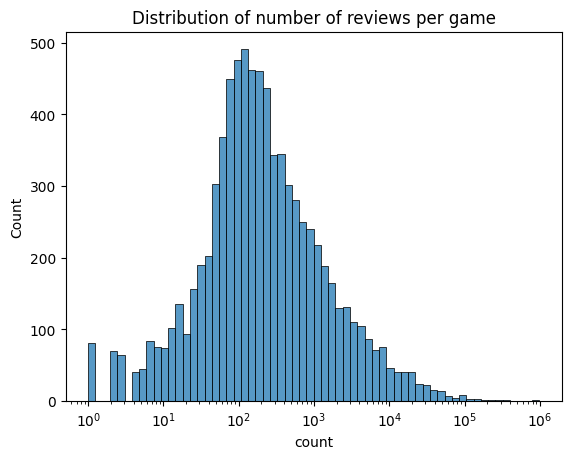

In [5]:
sns.histplot(df["app_id"].value_counts(), log_scale=True)
plt.title("Distribution of number of reviews per game");

In [11]:
df.sort_values(by="user_id")["user_id"].value_counts().sample(frac=0.05, random_state=20242412)

user_id
76561198293434888     1
76561198142472548     6
76561199032490400     3
76561198143212734     1
76561198003875797     1
                     ..
76561199030410349     1
76561198283999342     1
76561198162823263    14
76561198146677092     1
76561198041366487    12
Name: count, Length: 34882, dtype: int64

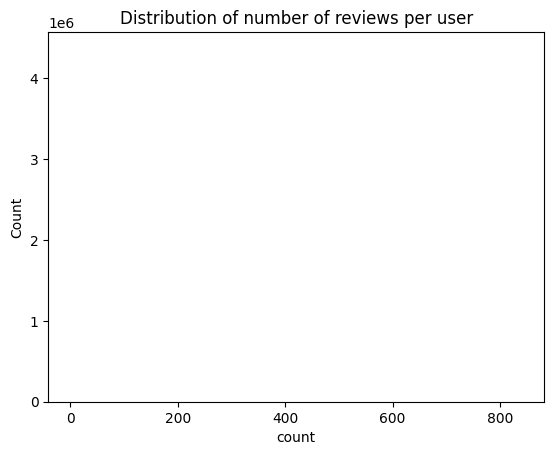

In [32]:
# distribution of mean voted_up per game
sns.histplot(
    df["user_id"]
    .value_counts(),
    # log_scale=True
    # .sample(frac=0.1, random_state=20242412),
)
plt.title("Distribution of number of reviews per user");

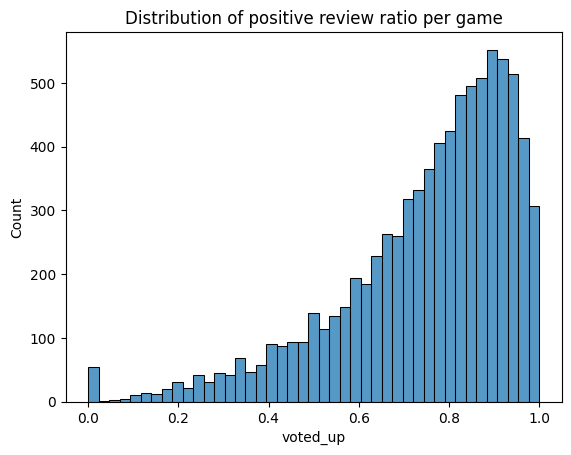

In [36]:
sns.histplot(df.groupby("app_id")["voted_up"].mean())
plt.title("Distribution of positive review ratio per game");

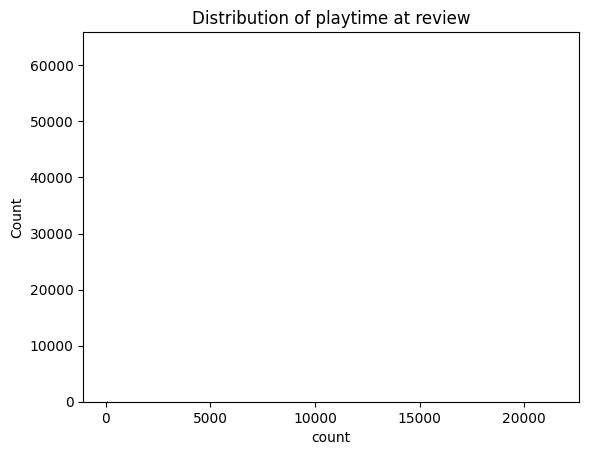

In [37]:
sns.histplot(df["playtime_at_review"].value_counts())
plt.title("Distribution of playtime at review");

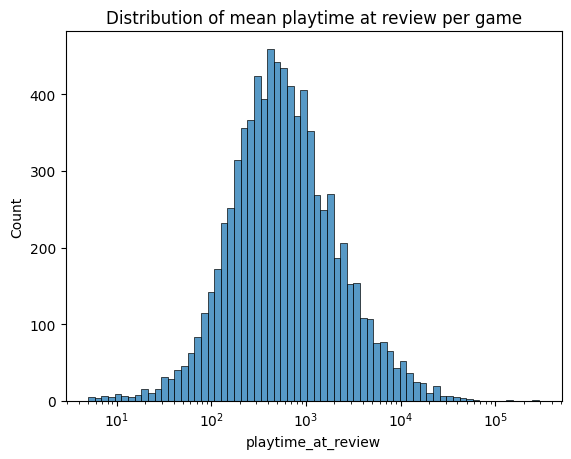

In [39]:
sns.histplot(df.groupby("app_id")["playtime_at_review"].mean(), log_scale=True)
plt.title("Distribution of mean playtime at review per game");

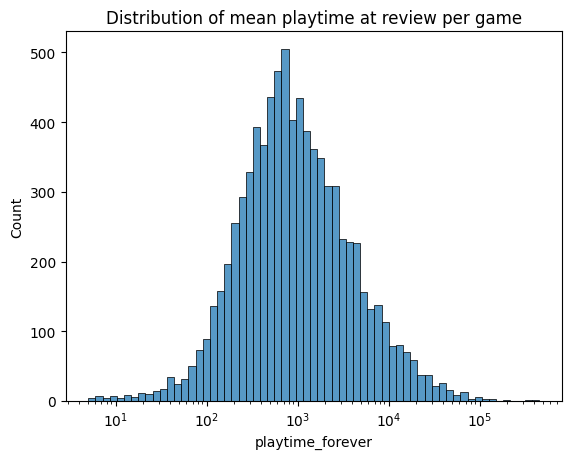

In [40]:
sns.histplot(df.groupby("app_id")["playtime_forever"].mean(), log_scale=True)
plt.title("Distribution of mean playtime at review per game");

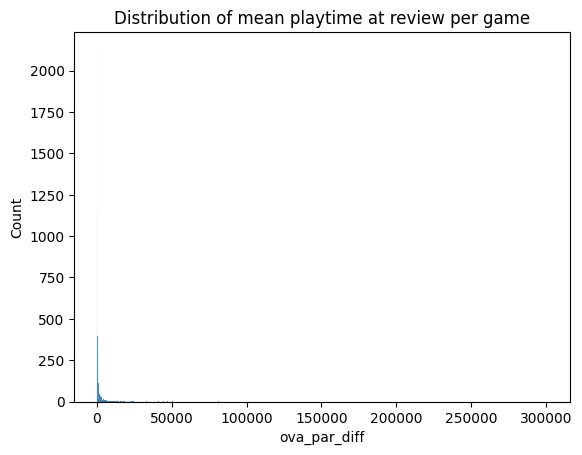

In [44]:
df["ova_par_diff"] = df["playtime_forever"] - df["playtime_at_review"]
sns.histplot(df.groupby("app_id")["ova_par_diff"].mean())
plt.title("Distribution of mean playtime at review per game");

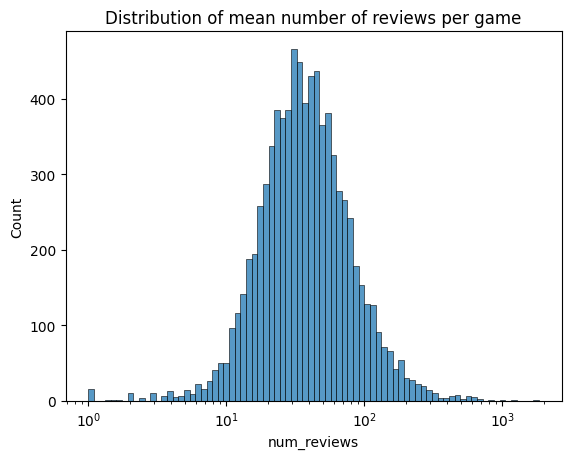

In [47]:
sns.histplot(df.groupby("app_id")["num_reviews"].mean(), log_scale=True)
plt.title("Distribution of mean number of reviews per game");

### Game recommendations on steam

In [48]:
df_games = (
    pd.read_csv("../data/raw/game-recommendations-on-steam/games.csv")
    .rename(columns={
        "date_release": "release_date",
        "price_final": "final_price",
        "price_original": "original_price",
        "win": "win_support",
        "mac": "mac_support",
        "linux": "linux_support",
        "steam_deck": "steam_deck_support",
    }).drop("discount", axis=1)
)
df_games.head()

,app_id,title,release_date,win_support,mac_support,linux_support,rating,positive_ratio,user_reviews,final_price,original_price,steam_deck_support
0,13500,Prince of Persia: Warrior Within™,2008-11-21,True,False,False,Very Positive,84,2199,9.99,9.99,True
1,22364,BRINK: Agents of Change,2011-08-03,True,False,False,Positive,85,21,2.99,2.99,True
2,113020,Monaco: What's Yours Is Mine,2013-04-24,True,True,True,Very Positive,92,3722,14.99,14.99,True
3,226560,Escape Dead Island,2014-11-18,True,False,False,Mixed,61,873,14.99,14.99,True
4,249050,Dungeon of the ENDLESS™,2014-10-27,True,True,False,Very Positive,88,8784,11.99,11.99,True


#### Platform support

In [79]:
for column in ["win_support", "mac_support", "linux_support", "steam_deck_support"]:
    print(f"{df_games[column].isna().sum()} missing values in {column}")

0 missing values in win_support
0 missing values in mac_support
0 missing values in linux_support
0 missing values in steam_deck_support


In [58]:
print(f"Percent of games with windows support: {df_games.win_support.mean()}")
print(f"Percent of games with mac support: {df_games.mac_support.mean()}")
print(f"Percent of games with linux support: {df_games.linux_support.mean()}")

Percent of games with windows support: 0.984352885673848
Percent of games with mac support: 0.2558971536405095
Percent of games with linux support: 0.17772055354615507


#### Ratings

In [59]:
for column in ["rating"]:
    print(f"{df_games[column].isna().sum()} missing values in {column}")

0 missing values in rating


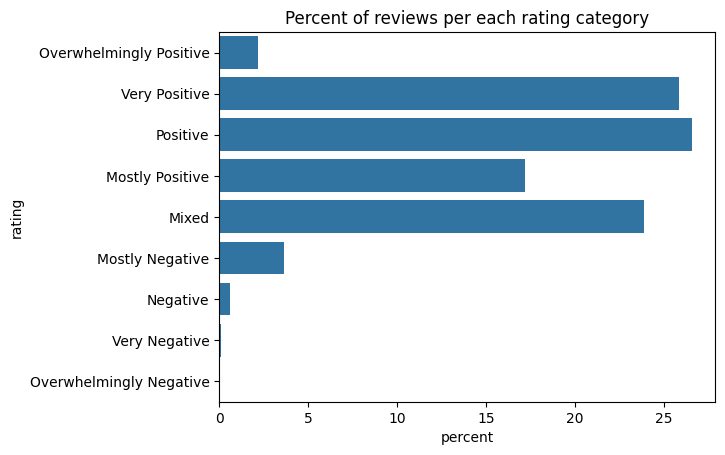

In [64]:
sns.countplot(
    data=df_games,
    y="rating",
    order=[
        "Overwhelmingly Positive", "Very Positive", "Positive", "Mostly Positive",
        "Mixed", "Mostly Negative", "Negative", "Very Negative", "Overwhelmingly Negative"],
    stat="percent",
)
plt.title("Percent of reviews per each rating category");

In [78]:
for column in ["release_date"]:
    print(f"{df_games[column].isna().sum()} missing values in {column}")

0 missing values in release_date


In [72]:
df_games["release_date"] = pd.to_datetime(df_games["release_date"])

In [75]:
df_games["release_year"] = df_games["release_date"].dt.year

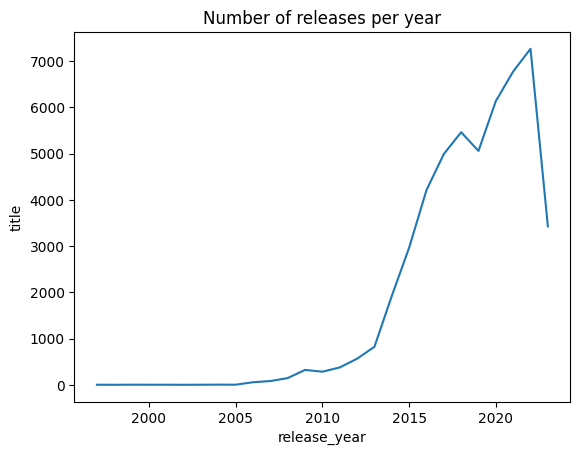

In [77]:
# number of releases per year
# may_flights = flights.query("month == 'May'")
sns.lineplot(data=df_games.groupby("release_year").count(), x="release_year", y="title")
plt.title("Number of releases per year");

In [ ]:
# number of releases per month

## Game features

- steam deck support
- linux support
- windows support
- mac support

Matching by description

In [153]:
# print(f"N games: {df_games_meta.shape[0]}")
# n_games_from_reviews_with_metadata = np.isin(df.appid.unique(), df_games_meta.app_id.to_numpy()).sum()
# print(f"N games from reviews dataset in game metadata dataset: {n_games_from_reviews_with_metadata}")
# print(f"N games from reviews dataset without metadata: {(df.appid.nunique() - n_games_from_reviews_with_metadata)}")

In [154]:
# df_games_meta.query("app_id == 8500")

### Steam games complete dataset

In [222]:
def convert_price_to_float(x):
    if isinstance(x, float):
        return x
    elif x.startswith("$"):
        return float(x.lstrip("$"))
    elif x == "Free":
        return 0
    else:
        return None
    # int(x.lstrip("$") if x.startswith("$") else (if )
    
df_games_complete = (
    pd.read_csv("../data/raw/steam-games-complete-dataset/steam_games.csv")
    .query("types == 'app' | types == 'bundle'")
    .rename(columns={"name": "title", "achievements": "n_game_achievements"})
    .assign(refined_price=lambda df: df["original_price"].apply(convert_price_to_float))
)
df_games_complete["app_id"] = (
    df_games_complete.url
    .str.removeprefix("https://store.steampowered.com/")
    .str.split("/")
    .apply(lambda x: x[1]).astype(int)
)
df_games_complete["app_id"] = df_games_complete["app_id"].astype(int)
df_games_complete.head()

,url,types,title,desc_snippet,recent_reviews,all_reviews,release_date,developer,publisher,popular_tags,...,n_game_achievements,genre,game_description,mature_content,minimum_requirements,recommended_requirements,original_price,discount_price,refined_price,app_id
0,https://store.steampowered.com/app/379720/DOOM/,app,DOOM,Now includes all three premium DLC packs (Unto...,"Very Positive,(554),- 89% of the 554 user revi...","Very Positive,(42,550),- 92% of the 42,550 use...","May 12, 2016",id Software,"Bethesda Softworks,Bethesda Softworks","FPS,Gore,Action,Demons,Shooter,First-Person,Gr...",...,54.0,Action,"About This Game Developed by id software, the...",NaN,"Minimum:,OS:,Windows 7/8.1/10 (64-bit versions...","Recommended:,OS:,Windows 7/8.1/10 (64-bit vers...",$19.99,$14.99,19.99,379720
1,https://store.steampowered.com/app/578080/PLAY...,app,PLAYERUNKNOWN'S BATTLEGROUNDS,PLAYERUNKNOWN'S BATTLEGROUNDS is a battle roya...,"Mixed,(6,214),- 49% of the 6,214 user reviews ...","Mixed,(836,608),- 49% of the 836,608 user revi...","Dec 21, 2017",PUBG Corporation,"PUBG Corporation,PUBG Corporation","Survival,Shooter,Multiplayer,Battle Royale,PvP...",...,37.0,"Action,Adventure,Massively Multiplayer",About This Game PLAYERUNKNOWN'S BATTLEGROUND...,Mature Content Description The developers de...,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$29.99,NaN,29.99,578080
2,https://store.steampowered.com/app/637090/BATT...,app,BATTLETECH,Take command of your own mercenary outfit of '...,"Mixed,(166),- 54% of the 166 user reviews in t...","Mostly Positive,(7,030),- 71% of the 7,030 use...","Apr 24, 2018",Harebrained Schemes,"Paradox Interactive,Paradox Interactive","Mechs,Strategy,Turn-Based,Turn-Based Tactics,S...",...,128.0,"Action,Adventure,Strategy",About This Game From original BATTLETECH/Mec...,NaN,"Minimum:,Requires a 64-bit processor and opera...","Recommended:,Requires a 64-bit processor and o...",$39.99,NaN,39.99,637090
3,https://store.steampowered.com/app/221100/DayZ/,app,DayZ,The post-soviet country of Chernarus is struck...,"Mixed,(932),- 57% of the 932 user reviews in t...","Mixed,(167,115),- 61% of the 167,115 user revi...","Dec 13, 2018",Bohemia Interactive,"Bohemia Interactive,Bohemia Interactive","Survival,Zombies,Open World,Multiplayer,PvP,Ma...",...,NaN,"Action,Adventure,Massively Multiplayer",About This Game The post-soviet country of Ch...,NaN,"Minimum:,OS:,Windows 7/8.1 64-bit,Processor:,I...","Recommended:,OS:,Windows 10 64-bit,Processor:,...",$44.99,NaN,44.99,221100
4,https://store.steampowered.com/app/8500/EVE_On...,app,EVE Online,EVE Online is a community-driven spaceship MMO...,"Mixed,(287),- 54% of the 287 user reviews in t...","Mostly Positive,(11,481),- 74% of the 11,481 u...","May 6, 2003",CCP,"CCP,CCP","Space,Massively Multiplayer,Sci-fi,Sandbox,MMO...",...,NaN,"Action,Free to Play,Massively Multiplayer,RPG,...",About This Game,NaN,"Minimum:,OS:,Windows 7,Processor:,Intel Dual C...","Recommended:,OS:,Windows 10,Processor:,Intel i...",Free,NaN,0.00,8500


In [223]:
for column, n_na in df_games_complete.isna().mean().where(lambda x: x > 0).dropna().items():
    print(f"Column: {column}, missing values percentage: {(n_na * 100):.2f}%")

Column: title, missing values percentage: 0.03%
Column: desc_snippet, missing values percentage: 32.56%
Column: recent_reviews, missing values percentage: 93.33%
Column: all_reviews, missing values percentage: 29.86%
Column: release_date, missing values percentage: 7.24%
Column: developer, missing values percentage: 0.84%
Column: publisher, missing values percentage: 12.55%
Column: popular_tags, missing values percentage: 6.66%
Column: game_details, missing values percentage: 1.27%
Column: languages, missing values percentage: 0.05%
Column: n_game_achievements, missing values percentage: 69.96%
Column: genre, missing values percentage: 1.07%
Column: game_description, missing values percentage: 6.58%
Column: mature_content, missing values percentage: 92.86%
Column: minimum_requirements, missing values percentage: 48.10%
Column: recommended_requirements, missing values percentage: 48.08%
Column: original_price, missing values percentage: 13.08%
Column: discount_price, missing values perc

So, original dataset's app id is the same as steam games complete dataset

### Game features

- type (app/bundle)
- desc snippet embedding
- N years from release date upon retrieval date
- developer encoded
- publisher encoded
- tags binary encoding
- languages
- n achievements
- genre one-hot
- description fasttext embedding
- minimum requirements?
- recommended requirements?
- original price
- single-player bool
- multi-player bool

## Matching datasets

In [174]:
## DOOM
test_game_id = 379720
print(df_games.query("app_id == @test_game_id").title)
print("-------------------")
print(df_games_complete.query("app_id == @test_game_id").title)
# print(df[df.appid == test_game_id].title)

47730    DOOM
Name: title, dtype: object
-------------------
0    DOOM
Name: title, dtype: object


In [175]:
df.query("app_id == @test_game_id").review.apply(lambda x: "doom" in str(x)).sum()

np.int64(3104)

In [176]:
## prince persia warrior within
test_game_id = 13500
print(df_games.query("app_id == @test_game_id").title)
print("-------------------")
print(df_games_complete.query("app_id == @test_game_id").title)
# print(df[df.appid == test_game_id].title)

0    Prince of Persia: Warrior Within™
Name: title, dtype: object
-------------------
3370    Prince of Persia: Warrior Within™
Name: title, dtype: object


In [177]:
df.query("app_id == @test_game_id").review.apply(lambda x: "doom" in str(x)).sum()

np.int64(2)

In [178]:
df_games_complete.types.unique()

array(['app', 'bundle'], dtype=object)

### Merge dataframes

In [228]:
duplicates = (("name", "title"), ("release_date", "date_release"), ("rating", "positive_ratio", "recent_reviews"))
games_joined = (
    df_games_complete.set_index("app_id")
    .join(df_games.set_index("app_id"), lsuffix="_sgcd", rsuffix="_grps")
    .drop([
        "url",
        "minimum_requirements", "recommended_requirements", # can be turned into features
         # can be turned into features
        "discount_price",
        "user_reviews", "rating", "positive_ratio", # can result in data leakage
        "final_price", "original_price_grps",
    ], axis=1)
    .assign(
        final_title=lambda df: df.apply(
            lambda row: (row.title_grps if not pd.isna(row.title_grps) else row.title_sgcd),
            axis=1),
    )
)
games_joined.columns

Index(['types', 'title_sgcd', 'desc_snippet', 'recent_reviews', 'all_reviews',
       'release_date_sgcd', 'developer', 'publisher', 'popular_tags',
       'game_details', 'languages', 'n_game_achievements', 'genre',
       'game_description', 'mature_content', 'original_price_sgcd',
       'refined_price', 'title_grps', 'release_date_grps', 'win_support',
       'mac_support', 'linux_support', 'steam_deck_support', 'final_title'],
      dtype='object')

In [235]:
for column, n_na in (
    games_joined.isna().mean()
    .where(lambda x: x > 0).dropna()
    .sort_values().items()):
    print(f"Column: \033[1m{column}\033[0m, missing values percentage: \033[1m{(n_na * 100):.2f}%\033[0m")

Column: title_sgcd, missing values percentage: 0.03%
Column: final_title, missing values percentage: 0.03%
Column: languages, missing values percentage: 0.05%
Column: developer, missing values percentage: 0.84%
Column: genre, missing values percentage: 1.07%
Column: game_details, missing values percentage: 1.27%
Column: game_description, missing values percentage: 6.58%
Column: popular_tags, missing values percentage: 6.66%
Column: release_date_sgcd, missing values percentage: 7.24%
Column: publisher, missing values percentage: 12.55%
Column: original_price_sgcd, missing values percentage: 13.08%
Column: refined_price, missing values percentage: 17.37%
Column: all_reviews, missing values percentage: 29.86%
Column: desc_snippet, missing values percentage: 32.56%
Column: steam_deck_support, missing values percentage: 52.50%
Column: title_grps, missing values percentage: 52.50%
Column: release_date_grps, missing values percentage: 52.50%
Column: win_support, missing values percentage: 52.

#### languages eda

In [243]:
unique_languages = set()
# games_joined.languages.str.split(",").explode().apply(lambda x: x.strip()).unique()
games_joined.languages.str.split(",").explode().str.strip().unique()

array(['English', 'French', 'Italian', 'German', 'Spanish - Spain',
       'Japanese', 'Polish', 'Portuguese - Brazil', 'Russian',
       'Traditional Chinese', 'Korean', 'Simplified Chinese', 'Arabic',
       'Portuguese', 'Turkish', 'Thai', 'Ukrainian', 'Czech',
       'Spanish - Latin America', 'Dutch', 'Hungarian', 'Danish',
       'Finnish', 'Norwegian', 'Swedish', 'Romanian', 'Greek',
       'Bulgarian', nan, 'Vietnamese',
       '#lang_#lang_spanish*#lang_full_audio', 'Slovakian',
       '(all with full audio support)', '#lang_german;',
       '#lang_#lang_#lang_english**#lang_full_audio*#lang_full_audio'],
      dtype=object)

In [244]:
languages_categories_to_include = ['English', 'French', 'Italian', 'German', 'Spanish - Spain',
       'Japanese', 'Polish', 'Portuguese - Brazil', 'Russian',
       'Traditional Chinese', 'Korean', 'Simplified Chinese', 'Arabic',
       'Portuguese', 'Turkish', 'Thai', 'Ukrainian', 'Czech',
       'Spanish - Latin America', 'Dutch', 'Hungarian', 'Danish',
       'Finnish', 'Norwegian', 'Swedish', 'Romanian', 'Greek',
       'Bulgarian','Vietnamese', "Slovakian"]

### genre eda

In [257]:
print(f"N unique genres: {games_joined.genre.str.split(",").explode().unique().shape[0]}")

N unique genres: 35


In [246]:
games_joined.genre.str.split(",").explode().unique()

array(['Action', 'Adventure', 'Massively Multiplayer', 'Strategy',
       'Free to Play', 'RPG', 'Indie', 'Early Access', 'Simulation',
       'Racing', 'Casual', 'Sports', 'Violent', 'Gore', 'Valve', nan,
       'Nudity', 'Animation & Modeling', 'Design & Illustration',
       'Utilities', 'Sexual Content', 'Game Development', 'Education',
       'Software Training', 'Web Publishing', 'Video Production',
       'Audio Production', 'Movie', 'Photo Editing', 'Accounting',
       'Documentary', 'Short', '360 Video', 'Tutorial', 'HTC'],
      dtype=object)

In [247]:
genres_to_include = ['Action', 'Adventure', 'Massively Multiplayer', 'Strategy',
       'Free to Play', 'RPG', 'Indie', 'Early Access', 'Simulation',
       'Racing', 'Casual', 'Sports', 'Violent', 'Gore', 'Valve', 'Nudity', 
       'Sexual Content', 'Education', 'Video Production', 'Short']

### popular tags eda

In [261]:
print(f"N unique tags in popular tags: {games_joined.popular_tags.str.split(",").explode().unique().shape[0]}")

N unique tags in popular tags: 377


- popular tags: average of target encoding, min of target encoding, max of target encoding

### additional preprocessing
- game details
- game description
- publisher
- all reviews
- mature_content
- recent_reviews

### na filling strategy
- developer: target encoding
- genre: 000000000 in binary encoding
- platform_supports: NaN as a category
- mature_content: NaN as a category

### new features
- diversity of languages
- diversity of popular tags
- diversity of genre

In [ ]:
games_joined["app_id"] = games_joined["app_id"].astype("category")
df["app_id"] = ga

In [264]:
%%time
joined_dataset = df.sort_values(by="app_id").join(games_joined.sort_values(by="app_id"), on="app_id", lsuffix="srd")

CPU times: user 8.82 s, sys: 17.2 s, total: 26 s
Wall time: 51.9 s


## Features

### Features

User
- mean played time to retrieval date
- sum played time to retrieval date
- sum voted up upon retrieval
- sum voted down upon retrieval
- mean games rating upon retrieval
- sum windows reviewed games
- sum linux reviewed games
- sum mac reviewed games
- sum owned games (upon retrieval?)
- num reviews (upon retrieval?)
- n games reviews by developer
- n games reviewed by publisher
- n apps upon retrieval
- n bundles upon retrieval


Game
- num reviews upon retrieval date
- mean playtime hours on reviews upon retrieval
- mean review rating upon retrieval date